###  Загрузка библиотек и глобальных переменных

In [269]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, anderson, jarque_bera
from scipy.stats import mannwhitneyu, shapiro, ttest_ind, kruskal, f_oneway, \
    pearsonr, spearmanr, chi2_contingency
from importlib import reload
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [270]:
%load_ext pycodestyle_magic
# %pycodestyle_on
pd.options.mode.chained_assignment = None  # default='warn'

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


#### Пользовательские функции

In [271]:
def cat_graph(df, cat_feat, size=32):
    '''
    Функция отрисовки круговых диаграмм для категориальных переменных.
    На вход: исходная таблица и список категориальных переменных.
    На выходе: графики
    '''
    cols = 1
    rows = int(np.ceil(len(cat_feat) / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(size, size))
    plt.tight_layout()

    count = -1
    for i in range(rows):
        count += 1
        col = cat_feat[count]
        df1 = pd.DataFrame(df.groupby([col])[col].count())
        axs[i].pie(x=df1[col],
                   labels=df1.index,
                   autopct='%1.1f%%',)
        axs[i].title.set_text(str(col))

    plt.suptitle('Круговые диаграммы категориальных признаков',
                 fontsize=20, y=1.05)

    plt.show()

In [272]:
def plot_hist(data, col_column):
    '''
    Функция отрисовки гистограмм и ящика с усами для количесвтенных переменных.
    На вход: исходная таблица и список количественных переменных.
    На выходе: графики
    '''
    rows = len(col_column)
    f, ax = plt.subplots(rows, 2, figsize=(8, 15))
    f.tight_layout()
    f.set_figheight(30)
    f.set_figwidth(14)
    plt.rcParams.update({'font.size': 18})

    for i, col in enumerate(col_column):
        sns.histplot(data[col], kde=True, bins=24, ax=ax[i, 0])
        sns.boxplot(data[col], ax=ax[i, 1])

        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
    plt.suptitle("Гистограмма и ящик с усами для количественных данных",
                 fontsize=22, y=1.01)
    plt.show()

In [273]:
def get_ohe(train, categ, ohe):
    temp_df = pd.DataFrame(data=ohe.transform(train[categ]),
                           columns=ohe.get_feature_names_out())
    data = pd.concat([train.reset_index(drop=True), temp_df], axis=1)
    data = data.drop(columns=categ, axis=1)
    return data

In [274]:
def check_data(data_df):
    pd.set_option('display.max_columns', None)

    print('\033[1m' + 'Изучим исходные данные' + '\033[0m')
    print(data_df.info())
    print(data_df.shape)

    missed_cells = data_df.isnull().sum().sum() / (data_df.shape[0] *
                                                   (data_df.shape[1] - 1))
    missed_rows = sum(data_df.isnull().sum(axis=1) > 0) / data_df.shape[0]
    print('\033[1m' + "\nПроверка пропусков" + '\033[0m')
    print("Количество пропусков: {:.0f}".format(data_df.isnull().sum().sum()))
    # print("Количество пропусков2: \n", data_df.isna().sum())
    print("Доля пропусков {:.1%}".format(missed_cells) + '\033[0m')
    print("Доля строк, содержащих пропуски {:.1%}".format(missed_rows))

    # duplicates
    print('\033[1m' + "\nПроверка на дупликаты" + '\033[0m')
    print('Количество полных дупликатов: ', data_df.duplicated().sum())
    duplicateRows = data_df[data_df.duplicated()]
    print(duplicateRows)

    # data
    print('\033[1m' + "\nПервые 5 строчек датасета" + '\033[0m')
    print(data_df.head())  # tail(7)

    print('\033[1m' + '\nОписание количественных данных:' + '\033[0m')
    print(data_df.describe().T)

    print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
    print(data_df.describe(include='object').T)

    print(
        '\033[1m' + '\nВывод уникальных значений'
        + 'по каждому категориальному признаку:'
        + '\033[0m')
    df_object = data_df.select_dtypes(include='object').columns

    for i in df_object:
        print('\033[1m' + '_' + str(i) + '\033[0m')
        print(data_df[i].value_counts())

In [275]:
def normal_sum_test(x, Ptest):
    """
    Функция проверяет нормальность/ненормальность распределения
    по сумме 3-х тестов: Шапиро, Андерсона-Дарлинга, Харке-Бера

    На выходе:
    1 - ненормальное распределение
    0 - нормальное распредление

    Принцип большинства заложен.
    Внутри есть функция расчёта критерия Андерсона,
    исходя из уровня значимсоти
    """

    def anderson_chois_sig(A, Ptest):
        if Ptest == 0.05:
            ander = A[2]
        elif Ptest == 0.01:
            ander = A[4]
        return ander

    def normalnost_anderson(x, Ptest):
        A2, crit, sig = anderson(x, dist='norm')
        ad_pass = (A2 < crit)
        norm = anderson_chois_sig(ad_pass, Ptest)
        if norm == False:
            return 1
        return 0

    # print(x)
    p_shapiro = shapiro(x)[1]
    p_jarque = jarque_bera(x)[1]

    if p_shapiro < Ptest:
        p_shapiros = 1
    else:
        p_shapiros = 0

    if p_jarque < Ptest:
        p_jarques = 1
    else:
        p_jarques = 0

    # 1 - ненормальное, 0 - нормальное
    p_anderson = normalnost_anderson(x, Ptest)

    p_sum = p_shapiros + p_anderson + p_jarques

    if (p_sum > 1):
        return 1
    else:
        return 0

In [276]:
def convert_to_pep(df):
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.lower()
    return df

In [277]:
def process_feelling(x):
    if x < 0:
        return "неизвестно"
    if x == 0:
        return "неприемлемо"
    return "приемлемо"

In [278]:
def process_comfort(x):
    if x < 1:
        return "неизвестно"
    if x < 2:
        return "очень неудобно"
    if x < 3:
        return "неудобно"
    if x <= 4:
        return "нормально"
    if x <= 5:
        return "комфортно"
    return "очень комфортно"

In [279]:
def process_closing(x):
    if x < 0:
        return "неизвестно"
    if x == 0:
        return "открыто"
    return "закрыто"

In [280]:
def process_connected(x):
    if x < 0:
        return "неизвестно"
    if x == 0:
        return "выключен"
    return "включен"

In [281]:
def convert_to_celsius(x):
    celsius = (x - 32) * 5 / 9.0
    return celsius

In [282]:
def count_of_adv(x):
    if x <= 1:
        return "мало"
    elif x == 2:
        return "средне"
    return "много"

In [283]:
def make_age_cat(x):
    if x <= 44:
        return 'молодой возраст'
    elif x <= 59:
        return 'средний возраст'
    return 'пожилой возраст'

In [284]:
def standart_rh(x):
    if x < 40:
        return "Ниже нормы"
    elif 40 <= x <= 60:
        return "Норма"
    return "Выше нормы"

In [285]:
def cheddok(coef, x, y):
    # для оценки силы связи будем использовать шкалу Чеддока
    if 0.5 <= abs(coef) <= 0.7:
        return f"Заметная связь между факторами {x} и {y}. Коэффициент корреляции = {coef}"
    elif 0.7 < abs(coef) <= 0.9:
        return f"Сильная связь между факторами {x} и {y}. Коэффициент корреляции = {coef}"
    elif 0.9 < abs(coef) <= 1:
        return f"Очень сильная связь между факторами {x} и {y}. Коэффициент корреляции = {coef}"

In [286]:
def printing(string, p):
    if p < 0.05:
        print(string, "влияние фактора на отклик обнаружено")
    else:
        print(string, "влияние фактора на отклик не обнаружено")

In [287]:
def corr(df, x, y):  # функция для расчета корреляции между двумя факторами
    if is_numeric_dtype(df[x]) and is_numeric_dtype(df[y]):
        if normal_sum_test(df[x], 0.05) == 1 and normal_sum_test(df[y],
                                                                 0.05) == 1:
            return round(pearsonr(df[x], df[y])[0], 3)
        return round(spearmanr(df[x], df[y])[0], 3)
    elif is_string_dtype(df[x]) and is_string_dtype(df[y]):
        df1 = df[[x, y]]
        tab = pd.crosstab(df1[x], df1[y])
        return round(math.sqrt(chi2_contingency(tab).statistic / (
                df1.shape[0] * (min(df1.shape) - 1))), 3)
    elif is_string_dtype(df[y]):
        x, y = y, x
    # расчет корреляционного значения Eta
    cat = df[x].unique()
    in_group = 0
    inter_group = 0
    for i in cat:
        df1 = df[df[x] == i]
        m = df1[y].mean()
        in_group += df1[y].apply(lambda x: (x - m) ** 2).sum()
        inter_group += df1[y].count() * (m - df[y].mean()) ** 2

    return round(inter_group / (in_group + inter_group), 3)

#### Загрузка данных

In [288]:
df = pd.read_csv("ya_climate.csv", sep=";", decimal=".")

In [289]:
# Проверка отработанного кода
df

,Год,Время года,Климат,Город,Страна,Способ охлаждения,Режим при смешанном типе охлаждения,Способ обогрева,Возраст,Пол,Ощущение температуры,Ощущение температуры (bool),Предпочтительное изменение температуры,Ощущение движения воздуха (bool),Предпочтительное изменение движения воздуха,Оценка комфорта,Утепление,Температура воздуха в помещении,Температура воздуха на улице,RH,Скорость воздуха,Рост,Вес,Занавески,Вентилятор,Окно,Двери,Отопление,Среднемесячная температура на улице,Количество рекламаций
0,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,22.0,NaN,0.0,1.0,Без изменений,NaN,Без изменений,3.5,0.54,22.9,22.8,48.9,0.26,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,0
1,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,40.0,NaN,-2.0,1.0,Без изменений,NaN,Без изменений,6.0,0.61,74.8,23.7,39.2,0.12,NaN,NaN,0.0,0.0,NaN,NaN,NaN,84.0,0
2,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,42.0,NaN,1.0,1.0,Без изменений,NaN,Без изменений,5.0,0.57,25.6,24.5,34.7,0.08,NaN,NaN,0.0,0.0,NaN,NaN,NaN,32.8,0
3,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,27.0,NaN,-0.5,0.0,Теплее,NaN,Без изменений,2.5,0.61,24.2,23.8,50.0,27.16,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,1
4,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,46.0,NaN,0.0,1.0,Без изменений,NaN,Меньше,4.5,0.57,23.8,24.1,35.8,63.83,NaN,NaN,1.0,1.0,NaN,NaN,NaN,32.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,2012.0,Лето,Влажный субтропический муссонный,Дели,Индия,Смешанный,Вентиляция,NaN,35.0,Мужской,0.0,1.0,Теплее,NaN,Без изменений,5.0,0.46,31.6,NaN,69.1,0.32,172.7,50.0,NaN,1.0,1.0,NaN,0.0,30.9,0
480,2012.0,Зима,Тропическая влажная саванна,Ченнай,Индия,Смешанный,Кондиционирование,NaN,NaN,Мужской,-1.0,1.0,Без изменений,NaN,Без изменений,NaN,0.64,26.5,NaN,61.0,0.16,NaN,65.0,NaN,NaN,0.0,0.0,NaN,30.8,0
481,2012.0,Зима,Жаркий полузасушливый,Хайдарабад,Индия,Смешанный,Кондиционирование,NaN,NaN,Женский,-1.0,1.0,Холоднее,NaN,Больше,NaN,0.74,26.9,NaN,42.0,0.02,NaN,76.0,NaN,NaN,0.0,0.0,NaN,21.6,0
482,2012.0,Зима,Жаркий полузасушливый,Хайдарабад,Индия,Смешанный,Кондиционирование,NaN,NaN,Женский,-1.0,1.0,Холоднее,NaN,Больше,NaN,0.74,26.9,NaN,42.0,0.02,NaN,76.0,NaN,NaN,0.0,0.0,NaN,21.6,0


#### Первичный осмотр данных

In [290]:
# ОПИСАТЕЛЬНЫЙ АНАЛИЗ
check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Год                                          484 non-null    float64
 1   Время года                                   484 non-null    object 
 2   Климат                                       484 non-null    object 
 3   Город                                        484 non-null    object 
 4   Страна                                       484 non-null    object 
 5   Способ охлаждения                            484 non-null    object 
 6   Режим при смешанном типе охлаждения          337 non-null    object 
 7   Способ обогрева                              222 non-null    object 
 8   Возраст                                      413 non-null    float64
 9   Пол                                          412 non-

In [291]:
# ГРАФИЧЕСКИЙ АНАЛИЗ количественных данных данных
num_features = df.select_dtypes(exclude=[object]).columns

# Проверка
num_features

Index(['Год', 'Возраст', 'Ощущение температуры', 'Ощущение температуры (bool)',
       'Ощущение движения воздуха (bool)', 'Оценка комфорта', 'Утепление',
       'Температура воздуха в помещении', 'Температура воздуха на улице', 'RH',
       'Скорость воздуха', 'Рост', 'Вес', 'Занавески', 'Вентилятор', 'Окно',
       'Двери', 'Отопление', 'Среднемесячная температура на улице',
       'Количество рекламаций'],
      dtype='object')

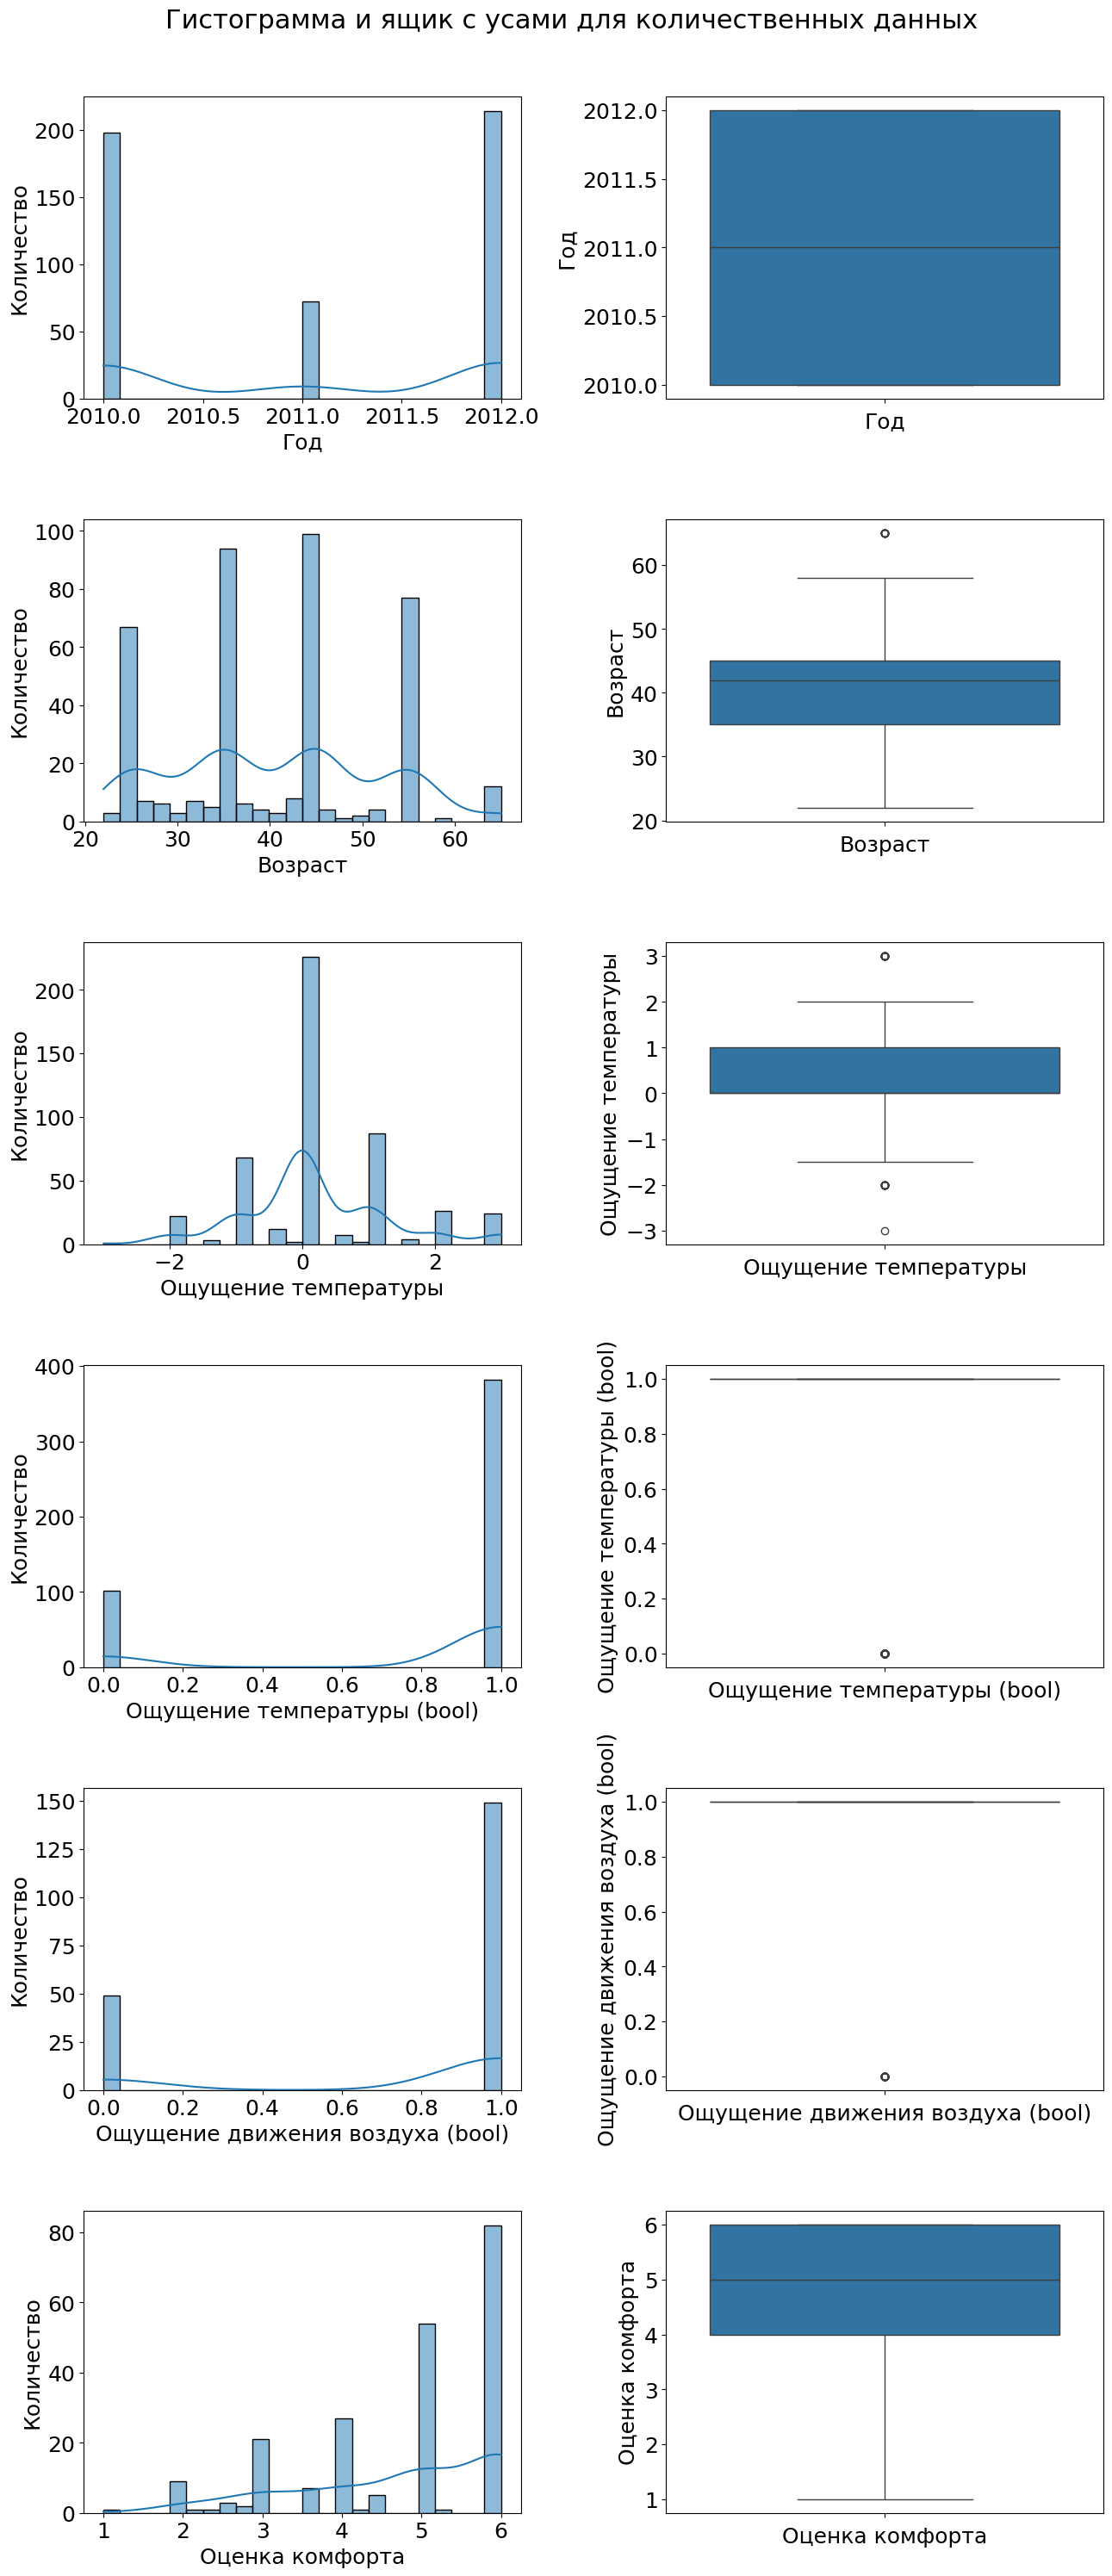

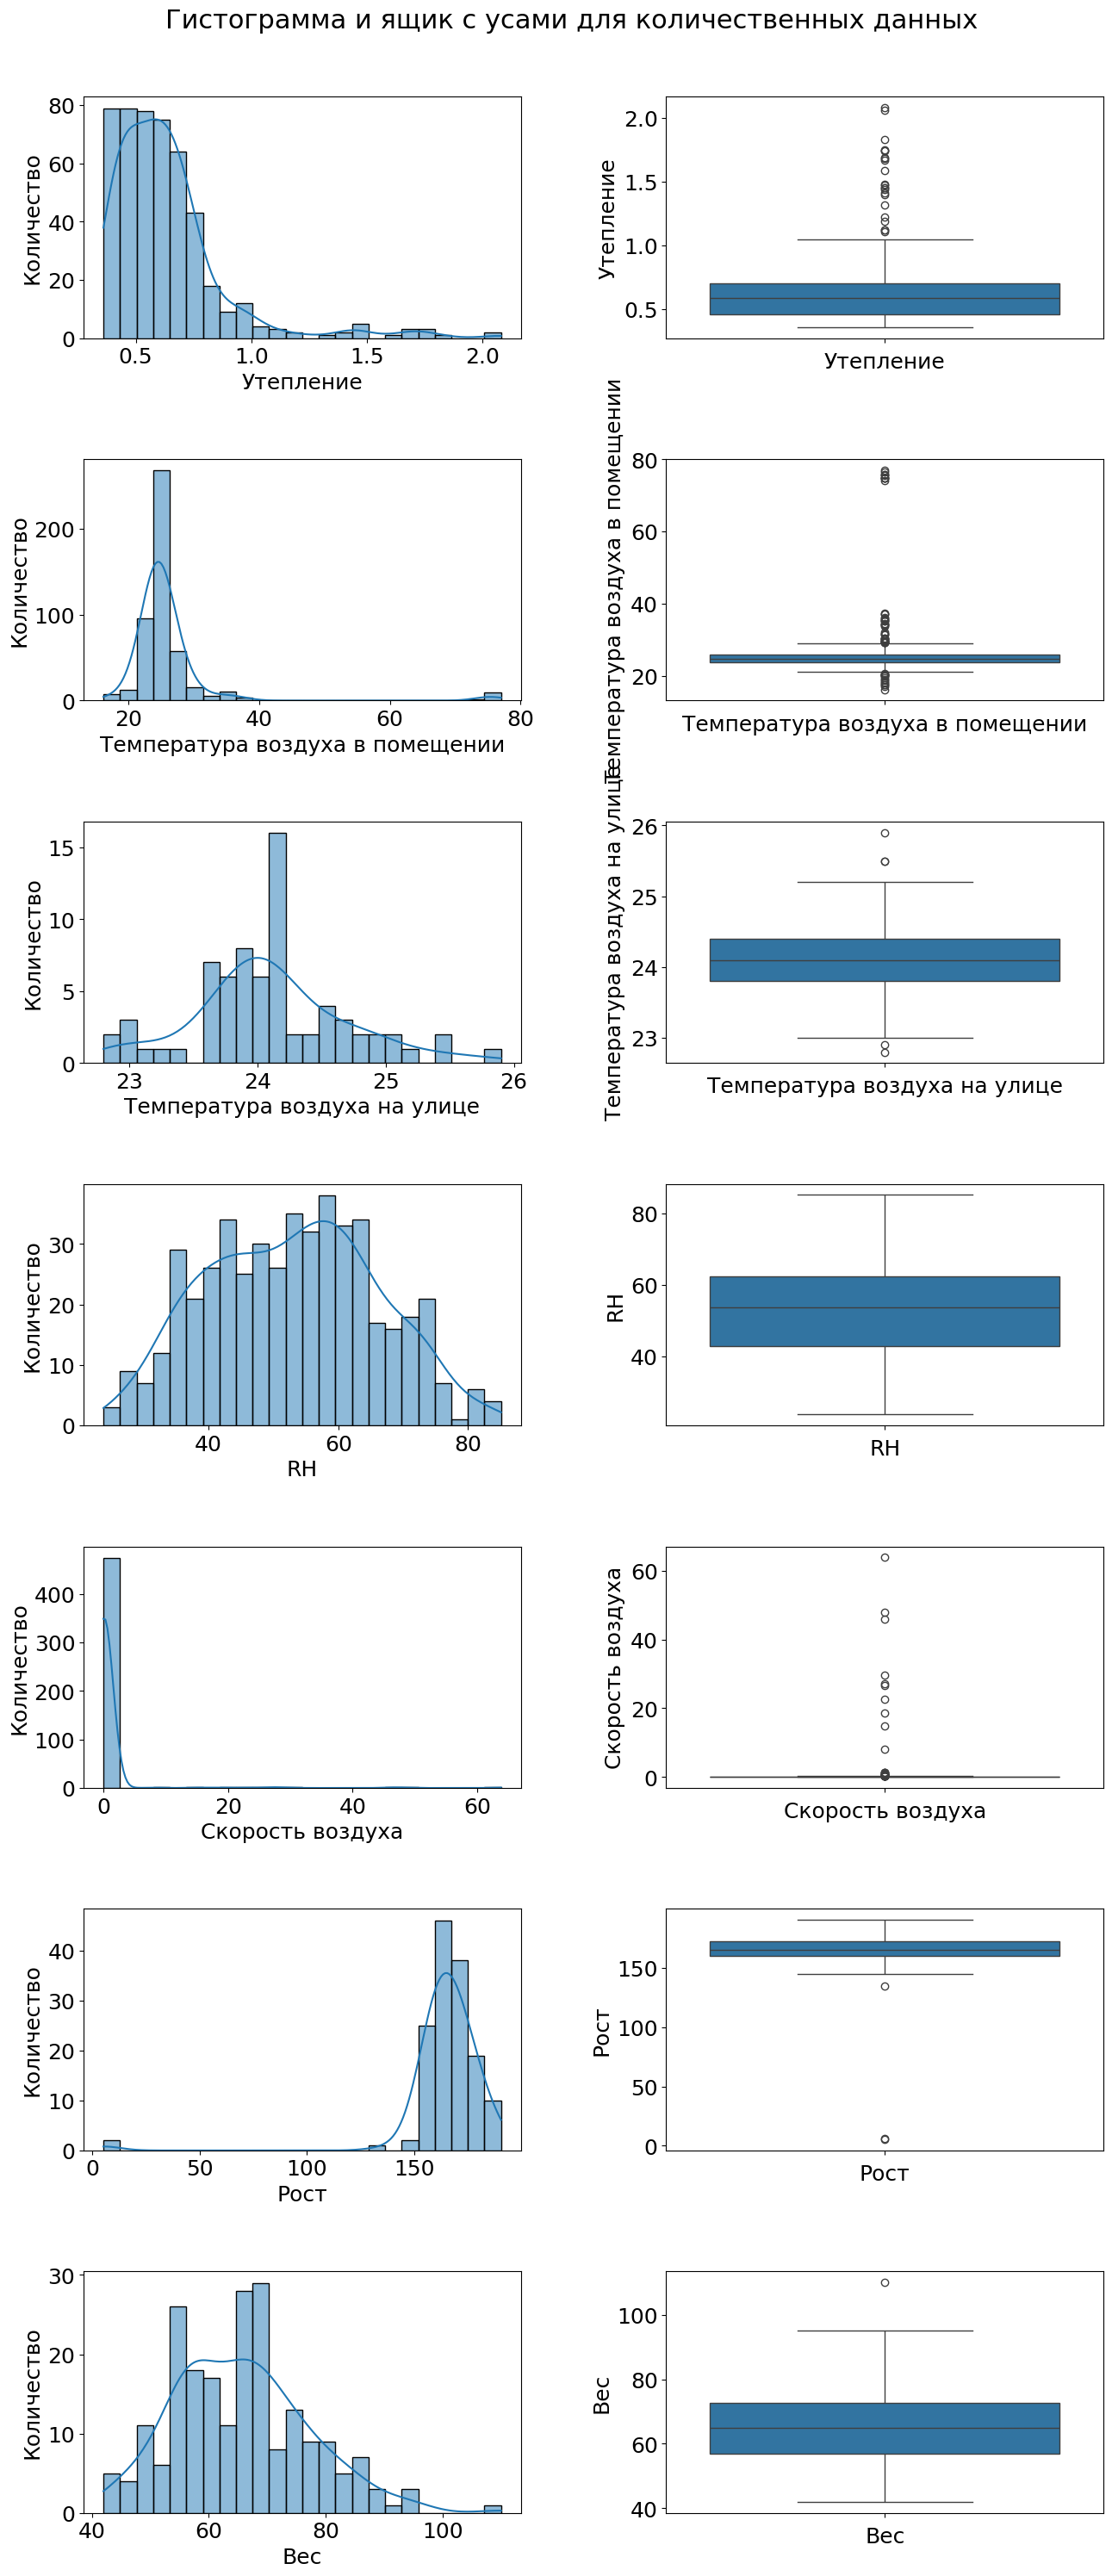

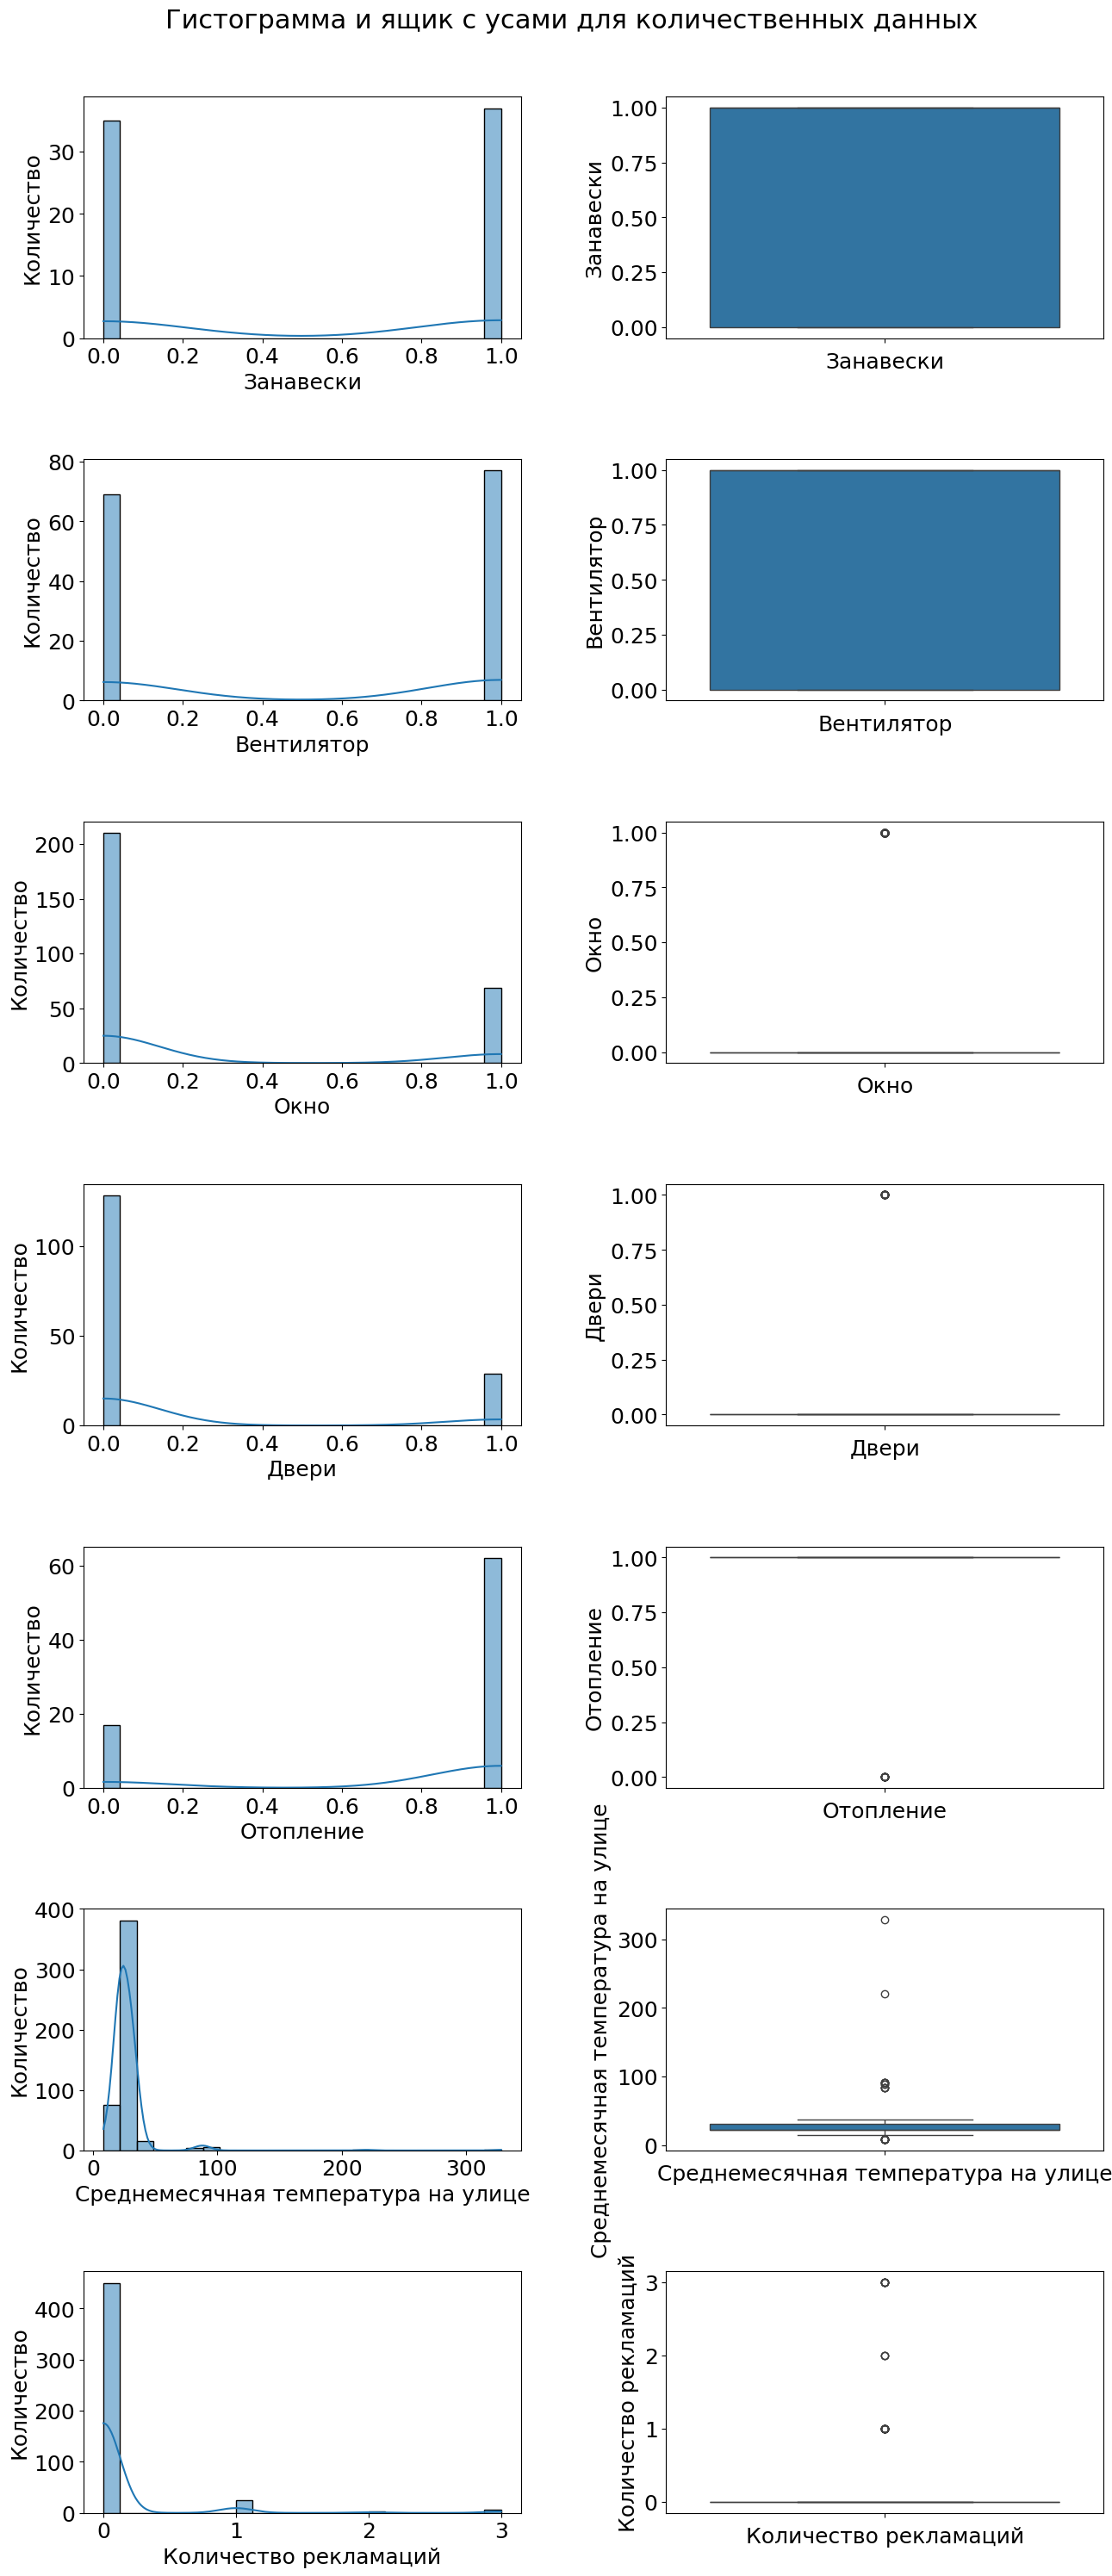

In [292]:
columns = df.select_dtypes(exclude=[object]).columns
num_features_1 = columns[:len(columns) // 3]
num_features_2 = columns[len(columns) // 3:len(columns) * 2 // 3]
num_features_3 = columns[len(columns) * 2 // 3:]

plot_hist(df, num_features_1)
plot_hist(df, num_features_2)
plot_hist(df, num_features_3)

In [293]:
# ГРАФИЧЕСКИЙ АНАЛИЗ категориальных данных
cat_features = df.select_dtypes(include=[object]).columns

# Проверка
cat_features

Index(['Время года', 'Климат', 'Город', 'Страна', 'Способ охлаждения',
       'Режим при смешанном типе охлаждения', 'Способ обогрева', 'Пол',
       'Предпочтительное изменение температуры',
       'Предпочтительное изменение движения воздуха'],
      dtype='object')

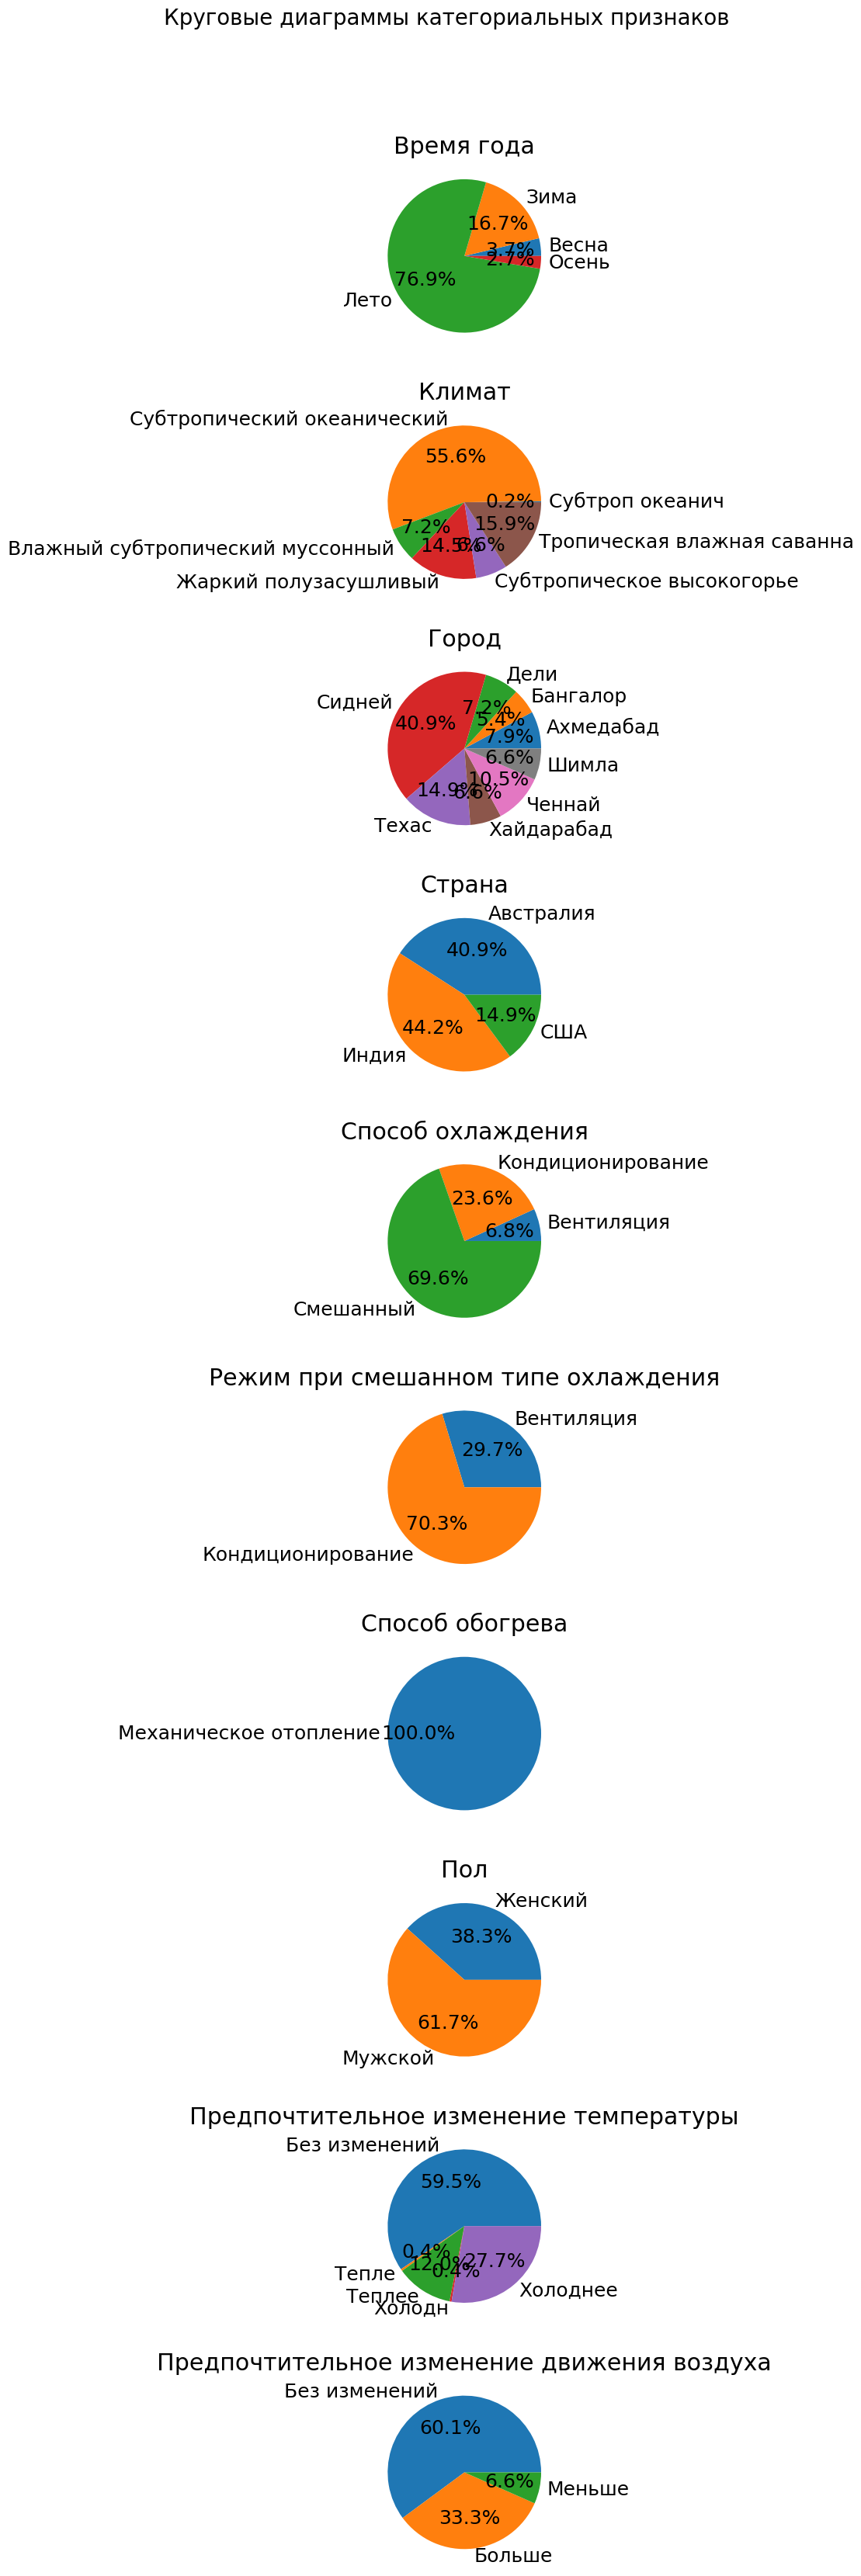

In [294]:
cat_graph(df, cat_features)

#### Выводы:

**Основная таблица:** 
* Привести названия столбцов в соответствие с требованием питона
* Количество полных дупликатов:  2, удаляем их
* В столбцах "Предпочтительное изменение температуры" и "Климат" название категорий требуют корректировок:
  * Тепле, Холодн
  * Субтроп океанич
* Пропуски есть, их большое количество 
  * Количество пропусков: 3817
  * Доля пропусков 27.2%
  * Обрабатываем пропуски в отдельном разделе (ниже)
* Есть выбросы
  * Температура воздуха в помещении (похоже, часть данных в шкале Фаренгейта). Требуется преобразование
  * Скорость воздуха
  * Рост
  * Среднемесячная температура воздуха на улице
  * Обрабатываем выбросы в отдельном разделе (ниже)
* Данные распределены, в основном, не нормально


### Подготовка данных

#### Работа с основной таблицей

##### Приведение названий столбцов к PEP8

In [295]:
df = convert_to_pep(df)

In [296]:
# ПРОВЕРКА ОТРАБОТКИ КОДА
df.head(1)

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,ощущение_температуры,ощущение_температуры_(bool),предпочтительное_изменение_температуры,ощущение_движения_воздуха_(bool),предпочтительное_изменение_движения_воздуха,оценка_комфорта,утепление,температура_воздуха_в_помещении,температура_воздуха_на_улице,rh,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
0,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,22.0,NaN,0.0,1.0,Без изменений,NaN,Без изменений,3.5,0.54,22.9,22.8,48.9,0.26,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,0


#### Меняем типы столбцов

In [297]:
df["год"] = df["год"].astype(int)

### Обработка отсутствующих значений

In [298]:
# удаление строк с отсутствующим возрастом
df = df.dropna(subset=["возраст"])
df["возраст"] = df["возраст"].astype(int)

In [299]:
col = "режим_при_смешанном_типе_охлаждения"
df[col] = df[col].fillna("отсутствует")

col = "способ_обогрева"
df[col] = df[col].fillna("отсутствует")

col = "пол"
df[col] = df[col].fillna("не указан")

col = "ощущение_движения_воздуха_(bool)"
df[col] = df[col].fillna(-1.0)
df[col] = df[col].apply(process_feelling)
df[col] = df[col].astype(object)

##### Пропуски в оценке комфорта заполняем средними значениями, сгруппированными по способу охлаждения

In [300]:
col = "оценка_комфорта"
df[col] = df[col].fillna(df.groupby(["способ_охлаждения"])[col].
                         transform("mean"))
df["оценка_комфорта_кат"] = df[col].apply(process_comfort)

##### Пропуски в температуре воздуха на улице заполняем средними значениями среднемесячной температуры на улице, сгруппированной по городу и времени года

In [301]:
col = "температура_воздуха_на_улице"
average_col = "среднемесячная_температура_на_улице"
df[col] = df[col].fillna(df.groupby(["город", "время_года"])[average_col].
                         transform("mean"))

##### Удаляем колонки рост и вес, так как в них слишком много пропусков

In [302]:
df.drop(["рост", "вес"], axis=1, inplace=True)

##### Преобразуем колонки ниже в категориальный тип, пропуски заполняем значениями "Не указано"

In [303]:
col = "занавески"
df[col] = df[col].fillna(-1.0)
df[col] = df[col].apply(process_closing)
df[col] = df[col].astype(object)

col = "вентилятор"
df[col] = df[col].fillna(-1.0)
df[col] = df[col].apply(process_connected)
df[col] = df[col].astype(object)

col = "окно"
df[col] = df[col].fillna(-1.0)
df[col] = df[col].apply(process_closing)
df[col] = df[col].astype(object)

col = "двери"
df[col] = df[col].fillna(-1.0)
df[col] = df[col].apply(process_closing)
df[col] = df[col].astype(object)

##### Значение колонки "Отопление" зависит от типа охлаждения. Заполняем пропуски значениями, в зависимости от типа охлаждения, преобразуем колонку в категориальный тип

In [304]:
col = "отопление"
df.loc[df["способ_охлаждения"] == "Кондиционирование", col] = 1.0
df.loc[df["режим_при_смешанном_типе_охлаждения"] == "Кондиционирование",
       col] = 1.0
df.loc[df["способ_охлаждения"] == "Вентиляция", col] = 0.0
df.loc[df["режим_при_смешанном_типе_охлаждения"] == "Вентиляция", col] = 0.0
df[col] = df[col].apply(lambda x: "выключено" if x == 0.0 else "включено")
df[col] = df[col].astype(object)

#### Обработка дубликатов

In [305]:
# удаляем дубликаты
df = df.drop_duplicates()

#### Обработка выбросов

In [306]:
# преобразуем выбросы
new_name = {"Cубтропический океанический": "Cубтропический океанический",
            "Cубтроп океанич": "Cубтропический океанический",
            "Субтропическое высокогорье": "Субтропическое высокогорье",
            "Тропическая влажная саванна": "Тропическая влажная саванна",
            "Жаркий полузасушливый": "Жаркий полузасушливый",
            "Влажный субтропический муссонный":
            "Влажный субтропический муссонный"}
df["климат"] = df["климат"].map(new_name)

new_name = {"Без изменений": "Без изменений",
            "Теплее": "Теплее",
            "Холоднее": "Холоднее",
            "Холодн": "Холоднее",
            "Тепле": "Теплее"}
col = "предпочтительное_изменение_температуры"
df[col] = df[col].map(new_name)

In [307]:
# убираем выбросы с помощью тройного интерквартильного размаха
col = "скорость_воздуха"
q1 = df[col].quantile(0.25)
q2 = df[col].quantile(0.75)
delta = q2 - q1
lower_bound = q1 - 3 * delta
upper_bound = q2 + 3 * delta
median = df[col].median()
df.loc[(df[col] < lower_bound), col] = median
df.loc[(df[col] > upper_bound), col] = median

#### Преобразуем температуру воздуха в помещении из шкалы Фаренгейта в шкалу Цельсия

In [308]:
col = "температура_воздуха_в_помещении"
df[col] = df[col].apply(lambda x: convert_to_celsius(x) if x > 50 else x)

#### Преобразуем среднемесячную температуру на улице. Явные выбросы заменяем на средние значения, сгруппированные по городу, остальные переводим из шкалы Фаренгейта в шкалу Цельсия

In [309]:
col = "среднемесячная_температура_на_улице"
mean_temp = df.groupby("город")[col].mean()
df.loc[df[col] > 100, col] = df["город"].map(mean_temp)
df[col] = df[col].apply(lambda x:
                        convert_to_celsius(x)
                        if x > 50 else x)

### Итоговая проверка работы с данными

In [310]:
# Ещё раз применим функцию первичного осмотра данных
check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
Index: 413 entries, 0 to 479
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          413 non-null    int32  
 1   время_года                                   413 non-null    object 
 2   климат                                       413 non-null    object 
 3   город                                        413 non-null    object 
 4   страна                                       413 non-null    object 
 5   способ_охлаждения                            413 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          413 non-null    object 
 7   способ_обогрева                              413 non-null    object 
 8   возраст                                      413 non-null    int32  
 9   пол                                          413 non-null 

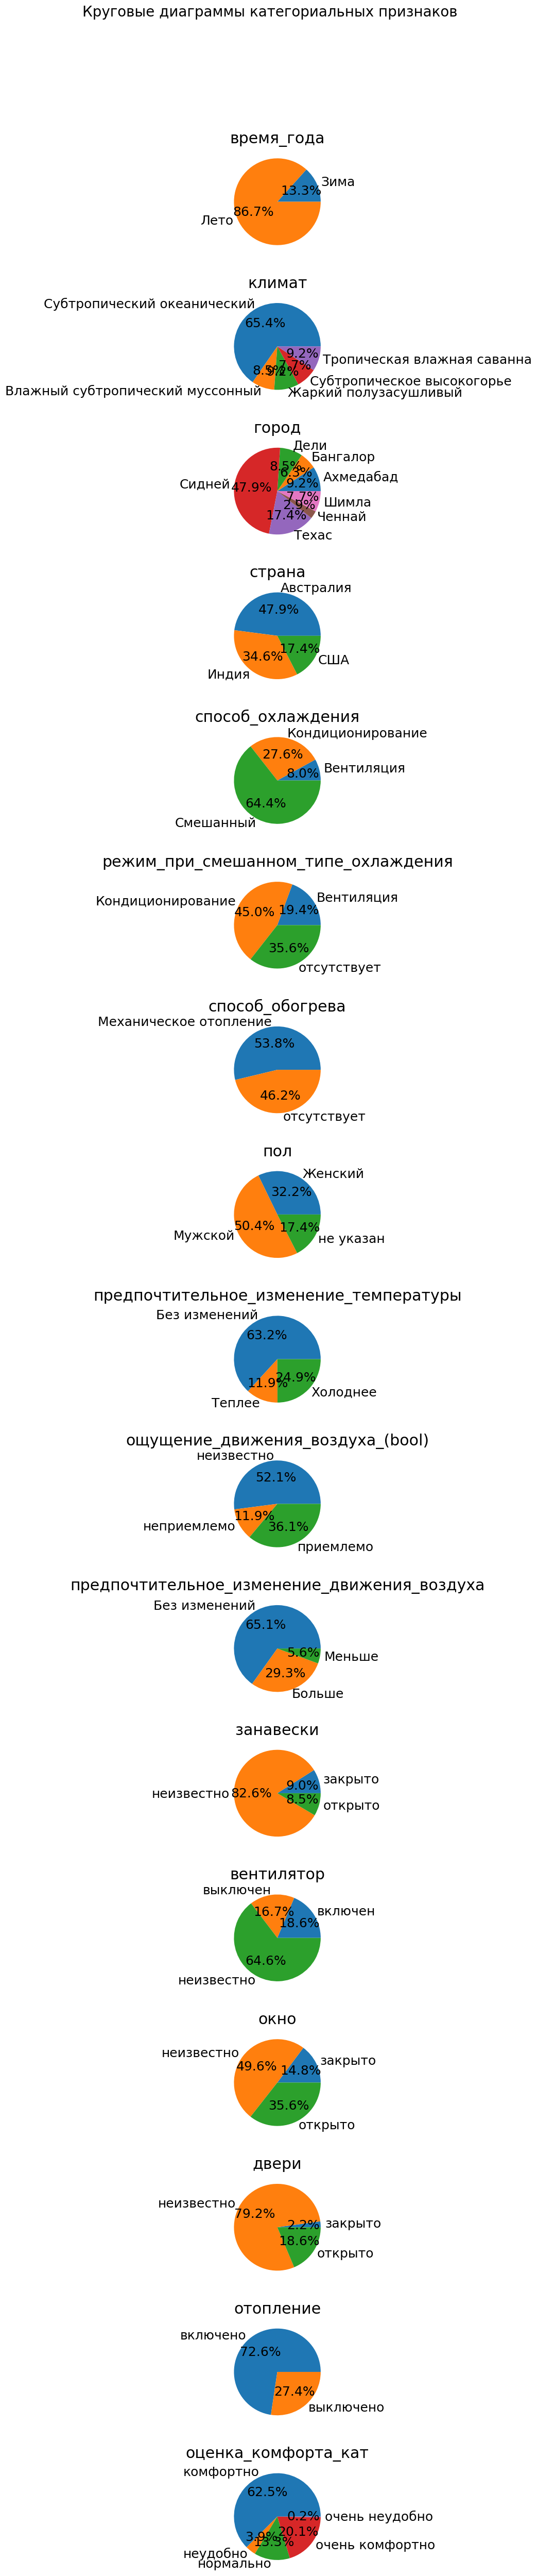

In [311]:
cat_graph(df, df.select_dtypes(include=[object]).columns, 48)

### Выводы по разделу

* Название столбцов в таблице приведены к стандарту PEP8
* Скорректированы типы колонок "Год" и "Возраст"
* Удалены строки с пропусками по возрасту, остальные пропуски заполнены
* Удалены колонки "рост" и "вес", так как в них много пропусков
* Устранены ошибки в названиях категорий
  * В колонке "Предпочтительное изменение температуры" скорректированы значения Тепле, Холодн
  * В колонке "Климат" скорректировано значение "Субтроп океанич"
* Обнаружен и удален полный дубликат
* Обнаружены и скорректированы выбросы по колонкам "скорость_воздуха", "температура_воздуха_в_помещении", "среднемесячная_температура_на_улице"
* Можно переходить к построению моделей

### Задание 2. Проведение расчетов и исследований

* Создать дополнительный категориальный столбец, который покажет количество рекламаций ко каждому клиенту отдельно: мало (≤1), средне (=2), много (>2)

In [312]:
col = "количество_рекламаций_кат"
df[col] = df["количество_рекламаций"].apply(count_of_adv)
df[col].unique()

array(['мало', 'много', 'средне'], dtype=object)

* Добавить категориальный столбец, разделив респондентов на три категории по возрасту: до 44 лет - молодой возраст, 45 - 59 лет - средний возраст, 60 лет и больше - пожилой возраст.

In [313]:
col = 'возрастная_группа'
df[col] = df['возраст'].apply(make_age_cat)
df[col].unique()

array(['молодой возраст', 'средний возраст', 'пожилой возраст'],
      dtype=object)

* Рассчитать среднюю комфортную температуру в зависимости от возрастной категории

In [314]:
# средняя комфортная температура в зависимости от возрастной категории
avg_comf_temp_age = pd.DataFrame(
    df[df["предпочтительное_изменение_температуры"] == "Без изменений"]
    .groupby("возрастная_группа")["температура_воздуха_в_помещении"]
    .apply(lambda x: round(x.sum() / x.count(), 1))
    ).rename(columns={"температура_воздуха_в_помещении":
                      "средняя_комфортная_температура"})
avg_comf_temp_age

,средняя_комфортная_температура
возрастная_группа,
молодой возраст,24.4
пожилой возраст,25.4
средний возраст,24.3


* Средний возраст респондентов по полу и стране

In [315]:
# средний возраст по полу и стране
avg_age = pd.DataFrame(
    df.groupby(["пол", "страна"])["возраст"].mean().round().astype(int)
    ).rename(columns={"возраст": "средний_возраст"})
avg_age

средний_возраст
пол       страна                    
Женский   Австралия               46
          Индия                   37
Мужской   Австралия               43
          Индия                   38
не указан США                     36

* Рассчитать медианное значение температуры и влажности для каждого типа охлаждения

In [316]:
# медианное значение температуры и влажности для каждого типа охлаждения
med_type_of_cool = pd.DataFrame(
    df.groupby("способ_охлаждения")[["температура_воздуха_в_помещении", "rh"]]
    .median()
    ).rename(columns={
             "температура_воздуха_в_помещении": "медианная_температура",
             "rh": "медианная_влажность"})
med_type_of_cool

,медианная_температура,медианная_влажность
способ_охлаждения,,
Вентиляция,25.300000,46.30
Кондиционирование,24.277778,42.45
Смешанный,24.400000,59.20


* Добавить столбец с процентом удовлетворенных респондентов температурой воздуха в помещении относительно всех респондентов одной страны и одного пола

In [317]:
# процент удовлетворенных температурой респондентов по стране и полу
df["удовлетворенность_температурой_%"] = df.groupby(
            ["страна", "пол"])[
            "предпочтительное_изменение_температуры"].transform(
            lambda x: round(x.value_counts(normalize=True)[0] * 100, 1))
df["удовлетворенность_температурой_%"]

C:\Temp\ipykernel_13652\2979381783.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: round(x.value_counts(normalize=True)[0] * 100, 1))
C:\Temp\ipykernel_13652\2979381783.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: round(x.value_counts(normalize=True)[0] * 100, 1))
C:\Temp\ipykernel_13652\2979381783.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: round(x.value_counts(normalize=True)[0] * 1

0      50.0
1      50.0
2      50.0
3      50.0
4      50.0
       ... 
473    67.7
474    67.7
475    52.3
476    67.7
479    67.7
Name: удовлетворенность_температурой_%, Length: 413, dtype: float64

* Составить сводную таблицу, в которой данные будут сгруппированы по стране, полу, возрастной группе и посчитаны средняя температура воздуха в помещении, на улице и средняя относительная влажность для каждой из этих групп.

In [318]:
'''
сводная таблица, в которой данные сгруппированы по стране, полу,
возрастной группе и посчитаны средняя температура воздуха в помещении,
на улице и средняя относительная влажность для каждой из этих групп.
'''
avg_temp_rh = df.groupby(["страна", "пол", "возрастная_группа"])[
    ["температура_воздуха_в_помещении", "температура_воздуха_на_улице",
        "rh"]].apply(lambda x:
                     round(x.sum() / x.count(), 1)).rename(
    columns={
        "температура_воздуха_в_помещении":
        "средняя_теспература_воздуха_в_помещении",
        "температура_воздуха_на_улице": "средняя_температура_воздуха_на_улице",
        "rh": "средняя_относительная_влажность"
    }
)
avg_temp_rh

средняя_теспература_воздуха_в_помещении  \
страна    пол       возрастная_группа                                            
Австралия Женский   молодой возраст                                       23.8   
                    пожилой возраст                                       24.9   
                    средний возраст                                       24.1   
          Мужской   молодой возраст                                       24.1   
                    пожилой возраст                                       24.7   
                    средний возраст                                       24.0   
Индия     Женский   молодой возраст                                       26.2   
                    средний возраст                                       24.2   
          Мужской   молодой возраст                                       24.8   
                    пожилой возраст                                       29.3   
                    средний возраст                                       26.2   
США       не указан молодой возраст                                       24.3   
                    средний возраст                                       24.4   

                                       средняя_температура_воздуха_на_улице  \
страна    пол       возрастная_группа                                         
Австралия Женский   молодой возраст                                    23.0   
                    пожилой возраст                                    23.0   
                    средний возраст                                    23.0   
          Мужской   молодой возраст                                    23.0   
                    пожилой возраст                                    23.0   
                    средний возраст                                    23.0   
Индия     Женский   молодой возраст                                    27.2   
                    средний возраст                                    21.8   
          Мужской   молодой возраст                                    26.0   
                    пожилой возраст                                    29.5   
                    средний возраст                                    22.8   
США       не указан молодой возраст                                    24.1   
                    средний возраст                                    24.1   

                                       средняя_относительная_влажность  
страна    пол       возрастная_группа                                   
Австралия Женский   молодой возраст                               61.4  
                    пожилой возраст                               44.6  
                    средний возраст                               61.3  
          Мужской   молодой возраст                               61.7  
                    пожилой возраст                               64.4  
                    средний возраст                               61.7  
Индия     Женский   молодой возраст                               51.3  
                    средний возраст                               49.9  
          Мужской   молодой возраст                               52.8  
                    пожилой возраст                               78.8  
                    средний возраст                               52.8  
США       не указан молодой возраст                               39.0  
                    средний возраст                               38.8

* Самостоятельно найти информацию по стандартной комфортной относительной влажности в помещениях (в нашем случае - офисы). Создать новый категориальный столбец, в котором будет показано, удовлетворяет ли зафиксированная относительная влажность стандарту или нет. Категории назначить самостоятельно.

In [319]:
# стандартная комфортная относительная влажность в офисах по СНиП: 40-60 %
# создадим категориальный столбец для влажности
df["rh_кат"] = df["rh"].apply(standart_rh)
df["rh_кат"].unique()

array(['Норма', 'Ниже нормы', 'Выше нормы'], dtype=object)

* Исследовать корреляцию между параметрами. Объяснить наиболее коррелирующие параметры, имеет ли это реальный смыл или просто особенность данных?

In [320]:
print(df.columns)
list_of_corr = []  # список всех взаимосвязей, которые имеют значение
for i in range(len(df.columns) - 1):
    for j in range(i + 1, len(df.columns)):
        coef = corr(df, df.columns[i], df.columns[j])
        if 1 >= abs(coef) >= 0.5:
            list_of_corr.append(
                [coef,
                 cheddok(coef, df.columns[i], df.columns[j])])
sorted(list_of_corr, key=lambda x: -abs(x[0]))

Index(['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения',
       'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст',
       'пол', 'ощущение_температуры', 'ощущение_температуры_(bool)',
       'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_(bool)',
       'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта',
       'утепление', 'температура_воздуха_в_помещении',
       'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'занавески',
       'вентилятор', 'окно', 'двери', 'отопление',
       'среднемесячная_температура_на_улице', 'количество_рекламаций',
       'оценка_комфорта_кат', 'количество_рекламаций_кат', 'возрастная_группа',
       'удовлетворенность_температурой_%', 'rh_кат'],
      dtype='object')


[[1.0,
  'Очень сильная связь между факторами год и город. Коэффициент корреляции = 1.0'],
 [1.0,
  'Очень сильная связь между факторами год и страна. Коэффициент корреляции = 1.0'],
 [1.0,
  'Очень сильная связь между факторами климат и страна. Коэффициент корреляции = 1.0'],
 [1.0,
  'Очень сильная связь между факторами город и ощущение_движения_воздуха_(bool). Коэффициент корреляции = 1.0'],
 [1.0,
  'Очень сильная связь между факторами город и занавески. Коэффициент корреляции = 1.0'],
 [1.0,
  'Очень сильная связь между факторами страна и ощущение_движения_воздуха_(bool). Коэффициент корреляции = 1.0'],
 [1.0,
  'Очень сильная связь между факторами страна и занавески. Коэффициент корреляции = 1.0'],
 [1.0,
  'Очень сильная связь между факторами способ_охлаждения и режим_при_смешанном_типе_охлаждения. Коэффициент корреляции = 1.0'],
 [1.0,
  'Очень сильная связь между факторами пол и занавески. Коэффициент корреляции = 1.0'],
 [0.954,
  'Очень сильная связь между факторами оценка_к

### Выводы по второй части
* Связь между страной(городом) и годом, объясняется тем, что данные по странам собраны в разные периоды времени. 
* Сильная связь между городом и способом обогрева.
* Сильная связь между городом и способом охлаждения.
* Сильную связь между страной(городом) и занавесками; вентилятором и занавесками можно объяснить тем, что данную информацию указывали в только в определенных городах
* Связь между полом и удовлетворенность_температурой_% необходимо исследовать
* СЧвязь между полом и способом охлаждения необходимо исследовать.
* Связь между городом и оценкой комфорта(категориальная) можно объяснить тем, что в некоторых городах система охлаждения настроена более оптимально
* Связь между ощущение_движения_воздуха_(bool) и оценка_комфорта_кат необходимо исследовать
* Связь между способ_охлаждения и ощущение_движения_воздуха_(bool) необходимо исследовать, т.к. возможно влияение на оценку комфорта.
* Связь способ_охлаждения и занавески видимо можно объяснить тем, что при определенных способах охлаждения занавески закрывают или открывают.
* Связь между ощущение_движения_воздуха_(bool) и вентилятором понятна.
* Заметная связь между способ_обогрева и оценка_комфорта_кат. Необходимо иссследовать.
* Заметная связь между вентилятор и оценка_комфорта_кат. Необходимо исследовать.
* Связь между окно и двери видимо объясняется тем, что окно и двери закрывают/открывают одновременно для создания микроклимата в помещении.
* Связь между способ_охлаждения и окно видимо объясняется тем, что при кондиционировании обычно окно закрыто.
* Заметная связь между способ_охлаждения,режим_при_смешанном_типе_охлаждения  и оценка_комфорта_кат. Необходимо исследовать.

### Задание 3. Проверка гипотез

#### Проверка каждой гипотезы имеет одно строение:
1. Формирование групп
2. Проверка их на нормальность
3. Вывод результата проверки с учётом нормальности распределения данных

* Влияет ли способ охлаждения на оценку комфорта?

In [321]:
# Проверка гипотезы о влиянии способа охлаждения на оценку комфорта
message = "Гипотеза о влиянии способа охлаждения на оценку комфорта:"

grp1 = df[df.способ_охлаждения == 'Кондиционирование']['оценка_комфорта']
grp2 = df[df.способ_охлаждения == 'Смешанный']['оценка_комфорта']
grp3 = df[df.способ_охлаждения == 'Вентиляция']['оценка_комфорта']
normal = normal_sum_test(grp1, 0.05) == 0 \
    and normal_sum_test(grp2, 0.05) == 0 \
    and normal_sum_test(grp3, 0.05) == 0
if normal:
    printing(message, f_oneway(grp1, grp2, grp3)[1])
else:
    printing(message, kruskal(grp1, grp2, grp3)[1])

Гипотеза о влиянии способа охлаждения на оценку комфорта: влияние фактора на отклик обнаружено


* Влияет ли пол на оценку комфорта?

In [322]:
# Проверка гипотезы о влиянии пола на оценку комфорта
message = "Гипотеза о влиянии пола на оценку комфорта:"

grp1 = df[df.пол == 'Мужской']['оценка_комфорта']
grp2 = df[df.пол == 'Женский']['оценка_комфорта']

normal = normal_sum_test(grp1, 0.05) == 0 \
    and normal_sum_test(grp2, 0.05) == 0
if normal:
    printing(message, ttest_ind(grp1, grp2, equal_var=False)[1])
else:
    printing(message, mannwhitneyu(grp1, grp2)[1])

Гипотеза о влиянии пола на оценку комфорта: влияние фактора на отклик обнаружено


* Влияет ли возрастная группа на оценку комфорта?

In [323]:
# Проверка гипотезы о влиянии возрастной группы на оценку комфорта
message = "Гипотеза о влиянии возрастной группы на оценку комфорта:"

grp1 = df[df.возрастная_группа == 'молодой возраст']['оценка_комфорта']
grp2 = df[df.возрастная_группа == 'средний возраст']['оценка_комфорта']
grp3 = df[df.возрастная_группа == 'пожилой возраст']['оценка_комфорта']
normal = normal_sum_test(grp1, 0.05) == 0 \
    and normal_sum_test(grp2, 0.05) == 0 \
    and normal_sum_test(grp3, 0.05) == 0
if normal:
    printing(message, f_oneway(grp1, grp2, grp3)[1])
else:
    printing(message, kruskal(grp1, grp2, grp3)[1])

Гипотеза о влиянии возрастной группы на оценку комфорта: влияние фактора на отклик не обнаружено


* Есть ли взаимосвязь между количеством рекламаций и оценкой комфорта?

In [324]:
# Проверка гипотезы о взаимосвязи количества рекламаций и оценки комфорта
message = "Гипотеза о взаимосвязи количества рекламаций и оценки комфорта:"

grp1 = df['оценка_комфорта']
grp2 = df['количество_рекламаций']
normal = normal_sum_test(grp1, 0.05) == 0 \
    and normal_sum_test(grp2, 0.05) == 0
if normal:
    printing(message, pearsonr(grp1, grp2)[1])
else:
    printing(message, spearmanr(grp1, grp2)[1])

Гипотеза о взаимосвязи количества рекламаций и оценки комфорта: влияние фактора на отклик обнаружено


* Проверить гипотезу о том, что средняя оценка комфорта отличается в зависимости от страны

In [325]:
# Проверка гипотезы о влиянии страны на оценку комфорта
message = "Гипотеза о влиянии страны на оценку комфорта:"

grp1 = df[df.страна == 'США']['оценка_комфорта']
grp2 = df[df.страна == 'Австралия']['оценка_комфорта']
grp3 = df[df.страна == 'Индия']['оценка_комфорта']
normal = normal_sum_test(grp1, 0.05) == 0 \
    and normal_sum_test(grp2, 0.05) == 0 \
    and normal_sum_test(grp3, 0.05) == 0
if normal:
    printing(message, f_oneway(grp1, grp2, grp3)[1])
else:
    printing(message, kruskal(grp1, grp2, grp3)[1])

Гипотеза о влиянии страны на оценку комфорта: влияние фактора на отклик обнаружено


* Проверка гипотезы о влиянии влажности на оценку комфорта

In [326]:
# Проверка гипотезы о влиянии влажности на оценку комфорта
message = "Гипотеза о влиянии влажности на оценку комфорта:"

grp1 = df['rh']
grp2 = df['оценка_комфорта']
normal = normal_sum_test(grp1, 0.05) == 0 \
    and normal_sum_test(grp2, 0.05) == 0
if normal:
    printing(message, pearsonr(grp1, grp2)[1])
else:
    printing(message, spearmanr(grp1, grp2)[1])

Гипотеза о влиянии влажности на оценку комфорта: влияние фактора на отклик не обнаружено


* Проверка гипотезы о влиянии скорости воздуха на оценку комфорта

In [327]:
# Проверка гипотезы о влиянии скорости воздуха на оценку комфорта
message = "Гипотеза о влиянии скорости воздуха на оценку комфорта:"

grp1 = df['скорость_воздуха']
grp2 = df['оценка_комфорта']
normal = normal_sum_test(grp1, 0.05) == 0 \
    and normal_sum_test(grp2, 0.05) == 0
if normal:
    printing(message, pearsonr(grp1, grp2)[1])
else:
    printing(message, spearmanr(grp1, grp2)[1])

Гипотеза о влиянии скорости воздуха на оценку комфорта: влияние фактора на отклик обнаружено


* Проверка гипотезы о влиянии температуры воздуха в помещении на оценку комфорта

In [328]:
# Проверка гипотезы о влиянии температуры воздуха в помещении
# на оценку комфорта
message = "Гипотеза о влиянии температуры воздуха в помещении"
message += "на оценку комфорта:"

grp1 = df['температура_воздуха_в_помещении']
grp2 = df['оценка_комфорта']
normal = normal_sum_test(grp1, 0.05) == 0 \
    and normal_sum_test(grp2, 0.05) == 0
if normal:
    printing(message, pearsonr(grp1, grp2)[1])
else:
    printing(message, spearmanr(grp1, grp2)[1])

Гипотеза о влиянии температуры воздуха в помещениина оценку комфорта: влияние фактора на отклик не обнаружено


* Проверка гипотезы о влиянии утепления на оценку комфорта

In [329]:
# Проверка гипотезы о влиянии утепления на оценку комфорта
message = "Гипотеза о влиянии тутепления на оценку комфорта:"

grp1 = df['утепление']
grp2 = df['оценка_комфорта']
normal = normal_sum_test(grp1, 0.05) == 0 \
    and normal_sum_test(grp2, 0.05) == 0
if normal:
    printing(message, pearsonr(grp1, grp2)[1])
else:
    printing(message, spearmanr(grp1, grp2)[1])

Гипотеза о влиянии тутепления на оценку комфорта: влияние фактора на отклик обнаружено


### Выводы по третьей части (Проверка гипотез)

* Исследовано 9 гипотез о влиянии факторов
* Обнаружено влияние фактора "способ охлаждения" на фактор "оценка комфорта"
* Обнаружено влияние фактора "пол" на фактор "оценка комфорта"
* Обнаружено влияние фактора "количество рекламаций" на фактор "оценка комфорта"
* Обнаружено влияние фактора "страна" на фактор "оценка комфорта"
* Обнаружено влияние фактора "скорость воздуха" на фактор "оценка комфорта"
* Обнаружено влияние фактора "утепление" на фактор "оценка комфорта"

### Часть 4. Регрессионное моделирование 

* Построить регрессионную модель температуры воздуха в помещении в зависимости от типа охлаждения и других значимых факторов

In [330]:
numerical_columns = ["температура_воздуха_на_улице",
                     "утепление", "rh"]
categorical_columns = ["способ_охлаждения", "отопление", "вентилятор",
                       "занавески", "климат", "способ_обогрева",
                       "двери", "окно"]
x = df[numerical_columns + categorical_columns]
y = df[["температура_воздуха_в_помещении"]]

SIZE = 0.15
RANDOM_STATE = 42

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=SIZE,
                                                    random_state=RANDOM_STATE)

ohe = OneHotEncoder(sparse_output=False, drop="first")
ohe.fit(x_train[categorical_columns])
x_train_new = get_ohe(x_train, categorical_columns, ohe)
x_test_new = get_ohe(x_test, categorical_columns, ohe)

scaler = StandardScaler()
scaler.fit(x_train[numerical_columns])
x_train_new[numerical_columns] = \
    scaler.transform(x_train_new[numerical_columns])
x_test_new[numerical_columns] = scaler.transform(x_test_new[numerical_columns])

regression = LinearRegression()
regression.fit(x_train_new, y_train)
prediction = regression.predict(x_test_new)

r2 = r2_score(y_test, prediction.flatten())
mape = mean_absolute_percentage_error(y_test, prediction.flatten())
mape = mape * 100
print(f"Результат работы модели: r2 = {round(r2, 2)}, MAPE = {round(mape, 2)}")
koef = pd.DataFrame(regression.coef_.flatten(), x_test_new.columns,
                    columns=["Коэффициенты"])
koef.sort_values(by="Коэффициенты", ascending=False)
print(koef)

Результат работы модели: r2 = 0.67, MAPE = 4.45
                                         Коэффициенты
температура_воздуха_на_улице                 1.167358
утепление                                   -0.681815
rh                                          -0.622773
способ_охлаждения_Кондиционирование         -3.676396
способ_охлаждения_Смешанный                 -1.151931
отопление_выключено                         -1.084373
вентилятор_выключен                         -3.543474
вентилятор_неизвестно                       -3.720072
занавески_неизвестно                         0.219481
занавески_открыто                            3.953630
климат_Влажный субтропический муссонный      3.805434
климат_Жаркий полузасушливый                 2.980101
климат_Субтропическое высокогорье            2.192941
климат_Тропическая влажная саванна           2.262801
способ_обогрева_отсутствует                 -2.041752
двери_неизвестно                             0.432796
двери_открыто                     

#### Графический анализ построенной модели

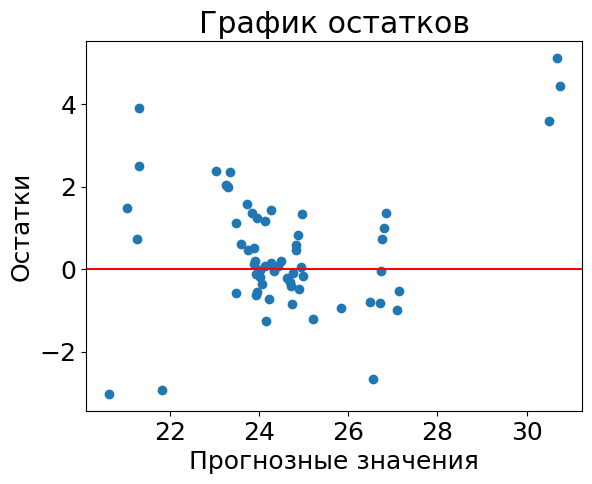

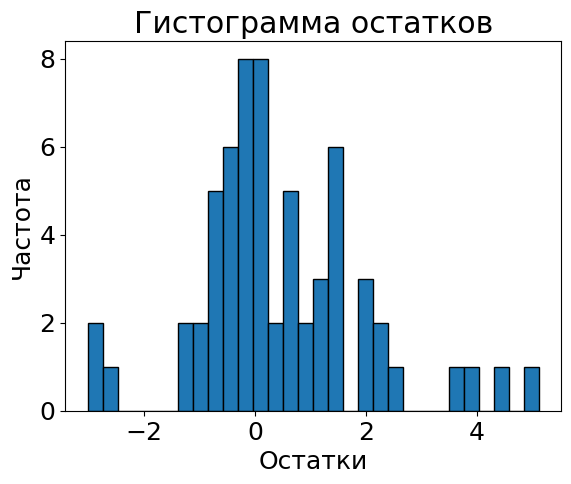

In [331]:
# вычислим остатки
residuals = y_test - prediction

plt.scatter(prediction, residuals)
# добавляем горизонтальную линию на уровне y=0 для наглядности
plt.axhline(y=0, color='r', linestyle='-')
plt.title('График остатков')
plt.xlabel('Прогнозные значения')
plt.ylabel('Остатки')
plt.show()
# Построение гистограммы с 30 бинами и черными границами
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

#### Выводы по четвертой части
* Построена модель линейной регрессии для фактора "температура воздуха в помещении"
* Для построения модели использовались факторы: "температура_воздуха_на_улице", "утепление", "rh", "способ_охлаждения", "отопление", "вентилятор", "занавески", "климат", "способ_обогрева", "двери", "окно"
* Из анализа коэффициентов линейной регрессии наибольшее влияние на модель оказывают факторы "способ охлаждения", "занавески", "климат", "отопление", "температура воздуха на улице"
* В результате работы модели на тестовых данных r2 (коэффициент детерминации, изменяется от 0 до 1) равен 0.67, а метрика MAPE (относительная ошибка в процентах - от 0 до 100) равна 4.45. Таким образом, выбранные факторы на 67% влияют на модель, а ошибка 4.45% является достаточно низкой